In [1]:
from dask.distributed import Client
import multiprocessing
ncpu = multiprocessing.cpu_count()
threads = 6
nworker = ncpu//threads
print(f'Number of CPUs: {ncpu}, number of threads: {threads}, number of workers: {nworker}')

Number of CPUs: 72, number of threads: 6, number of workers: 12


In [2]:
client = Client(processes=True, threads_per_worker=threads, n_workers=nworker, memory_limit='256GB')
client

Client Scheduler: tcp://127.0.0.1:37444 Dashboard: http://localhost:8888/proxy/8787/status,Cluster Workers: 12 Cores: 72 Memory: 805.87 GB


# Intake to load CMIP data

### Using intake-esm on mistral
- install intake-esm: https://intake-esm.readthedocs.io/en/latest/installation.html
- check the already built catalogs: `/home/mpim/m300524/intake-esm-datastore/catalogs` or `https://github.com/NCAR/intake-esm-datastore/` and skip long catalog building process of running `/home/mpim/m300524/intake-esm-datastore/builders/*.ipynb`

In [3]:
import intake
import xarray as xr
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import pprint
warnings.simplefilter("ignore")
%matplotlib inline
xr.set_options(keep_attrs=True)
import intake_esm
import pymistral
import cartopy.crs as ccrs
from climpred.stats import dpp, varweighted_mean_period
cmip6_post = '/work/mh0727/m300524/DCPP_post'

In [4]:
intake_esm.__version__

'2019.10.15.post33'

Credits to Julius Busecke for creating `cmip6_preprocessing`: https://github.com/jbusecke/cmip6_preprocessing

In [5]:
from cmip6_preprocessing.preprocessing import combined_preprocessing
##combined_preprocessing??

# CMIP6

In [6]:
col_url = "/home/mpim/m300524/intake-esm-datastore/catalogs/mistral-cmip6.json"
col = intake.open_esm_datastore(col_url)

In [14]:
variable='tas'
table_id='Amon'

In [15]:
#variable='tos'
#table_id='Omon'

### hindcast

In [17]:
query = dict(experiment_id=['dcppA-hindcast'], table_id=table_id, variable_id=variable)
cat = col.search(**query)

print(cat.df['source_id'].unique())

['CESM1-1-CAM5-CMIP5' 'MPI-ESM1-2-HR' 'NorCPM1']


In [10]:
#cat.df.head()

In [10]:
def climpred_pre(ds):
    """CMIP6 DCPP preprocessing before the aggreatations of intake-esm happen."""
    # sometimes there is a small error in combined_preprocessing, therefore only try
    try:
        ds = combined_preprocessing(ds)
    except:
        print('preproc didnt work')
    # set time to integers starting at 1
    ds['time'] = np.arange(1,1 + ds.time.size)
    return ds

In [11]:
cdf_kwargs={'chunks': {'time': 120},'decode_times': False}
dset_dict = cat.to_dataset_dict(cdf_kwargs=cdf_kwargs, preprocess=climpred_pre)

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 3 group(s)


In [12]:
# available output
dset_dict.keys()

dict_keys(['DCPP.MPI-M.MPI-ESM1-2-HR.dcppA-hindcast.Amon.gn', 'DCPP.NCAR.CESM1-1-CAM5-CMIP5.dcppA-hindcast.Amon.gn', 'DCPP.NCC.NorCPM1.dcppA-hindcast.Amon.gn'])

In [13]:
# get first output
ds = dset_dict[list(dset_dict.keys())[0]].rename({
    'member_id':'member','dcpp_init_year':'init','time':'lead'})[variable].squeeze()

In [14]:
ds.nbytes/1e9,'GB'

(9.064434816, 'GB')

### assimilation

In [16]:
query = dict(experiment_id=['dcppA-assim'], table_id=table_id, variable_id=variable)
cat_assim = col.search(**query)

print(cat_assim.df['source_id'].unique())

['MIROC6']


In [150]:
dset_dict_assim = cat_assim.to_dataset_dict(cdf_kwargs=cdf_kwargs, preprocess=climpred_pre)

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


In [152]:
dset_dict_assim.keys()

dict_keys(['DCPP.MIROC.MIROC6.dcppA-assim.Amon.gn'])

In [ ]:
# get the matching assimilation
assim = dset_dict_assim.keys()[0]

# annual predictions

In [118]:
def yearmean(ds, dim='time',initial_month='1'):
    was_int = False
    if isinstance(ds[dim].values[0], (np.int64, int)):
        print('set monthly time axis')
        was_int = True
        init_year = '0002' if initial_month is '1' else '0001'
        print(f'{init_year} {initial_month}')
        new_dim = xr.cftime_range(start=f'{init_year}-{str(initial_month).zfill(2)}',periods=ds[dim].size,freq='M')
        ds[dim] = new_dim
    #print(ds[dim])
    ds = ds.groupby(f'{dim}.year').mean(dim).rename({'year': dim})
    if not was_int:
        ds[dim] = xr.cftime_range(start=f'{init_year}-{str(initial_month).zfill(2)}',periods=ds[dim].size,freq='A')
    else:
        print('set one year back')
        ds[dim] = ds[dim] - 1
    return ds

In [136]:
# reload
#model = 'MPI-ESM1-2-HR'
#filename = f'{cmip6_post}/hind_{model}_{variable}.nc'
#ds = xr.open_mfdataset(filename,chunks={'lead':12})[variable]

In [137]:
ds = yearmean(ds,dim='lead', initial_month=11).load()
#assim = yearmean(assim,dim='time')

set monthly time axis
0001 11


In [138]:
from climpred.prediction import compute_perfect_model
from climpred.stats import rm_trend

In [140]:
# detrend
ds = rm_trend(ds.isel(lead=slice(1,None)),dim='lead')
#assim = rm_trend(assim,dim='time')

In [142]:
s = compute_perfect_model(ds,ds,metric='pearson_r',comparison='m2e')
#s = compute_hindcast(ds,assim,metric='pearson_r',comparison='e2r')

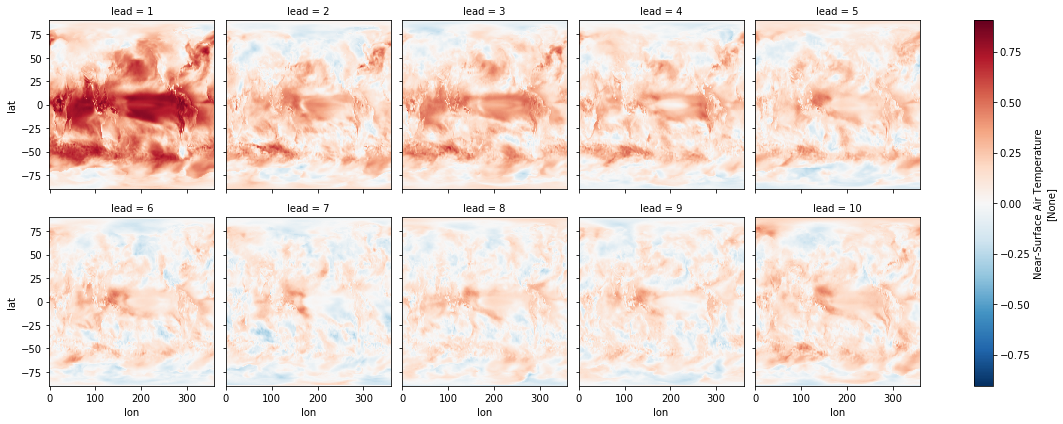

In [144]:
s.plot(col='lead',col_wrap=5)

#### intermediate saving

In [ ]:
# save to file
for key,value in dset_dict.items():
    ds = dset_dict[key].rename({
    'member_id':'member','dcpp_init_year':'init','time':'lead'})[variable].squeeze()
    model = key.split('.')[2]
    filename = f'{cmip6_post}/hind_{model}_{variable}.nc'
    print(ds.nbytes/1e9,'GB',filename)
    try:
        if not os.path.exists(filename):
            ds.to_dataset(name=variable).to_netcdf(filename)
    except:
        print(f'{filename} error')